In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# classifiers we will use
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import f1_score

# plotting
from plotting import plot_learning_curve, plot_validation_curve

#dataset
from sklearn.datasets import load_digits


## Digit Classification

In this notebook you will practice making different ensemble classifiers working with a set of handwritten digits. Sklearn gives us a copy of the test set (so it will be smaller than decription you read below).

Our aim is to build some models and practice with the parameters. We want to adjust things like
* number of estimators
* base-estimators parameters

Our analysis will be very similar to the last lab, we want to visualize how the parameters are affecting the performance so we can make validation curves. 

Let's get started!


In [2]:
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
data.target

array([0, 1, 2, ..., 8, 9, 8])

In [4]:
print(data.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [5]:
X = data.data # data is the flattened version of the images
y = data.target

In [6]:
data.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [7]:
data.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
print(data.images[2])

[[ 0.  0.  0.  4. 15. 12.  0.  0.]
 [ 0.  0.  3. 16. 15. 14.  0.  0.]
 [ 0.  0.  8. 13.  8. 16.  0.  0.]
 [ 0.  0.  1.  6. 15. 11.  0.  0.]
 [ 0.  1.  8. 13. 15.  1.  0.  0.]
 [ 0.  9. 16. 16.  5.  0.  0.  0.]
 [ 0.  3. 13. 16. 16. 11.  5.  0.]
 [ 0.  0.  0.  3. 11. 16.  9.  0.]]


## Plotting a few samples

It's always a good idea to "look" at our data. Our data is handwritten digits and in fact that means they are stored as 8x8 matrices.  This is stored in `data.images`.  So let's plot a few of those and see what they look like.

The astute reader will notice that we have used this code before, in fact we looked at this dataset in the intro notebook.

In [9]:
print(data.images[0])


[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


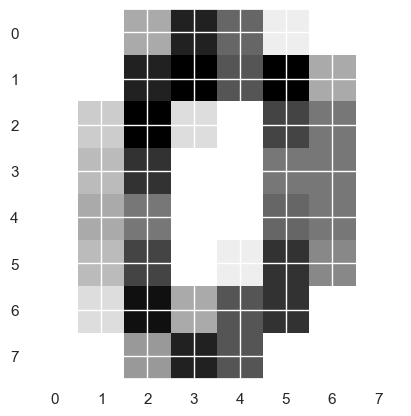

In [10]:
plt.imshow(data.images[0], cmap='binary', interpolation='nearest');


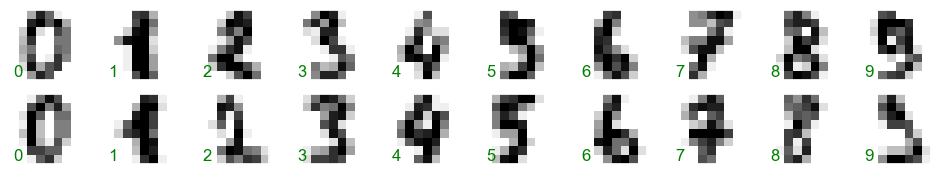

In [11]:
fig, axes = plt.subplots(2, 10, figsize=(12, 2))

for i, ax in enumerate(axes.flat):
    ax.imshow(data.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(data.target[i]),
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

Okay! Some blurry images.  However, we won't be doing our classification on 8x8 pictures, because all the algorithms we currently know need row vector samples, we will need to `flatten` our images into long vectors that are (64,) in shape (if this sounds insane to you, it is -- but it works surprisingly well, however you would like to learn convolutional neural networks (CNN's) in your future!).  But sklearn is so kind that they have already done this for us, so we just take our data from `data.data` (instead of `data.images`)

### AdaBoostClassifier and RandomForestClassifier!

We want AdaboostClassifier and a RandomForestClassifier.
Go ahead and read the documentation for both of these models and try out the different parameters.


my_decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)
ada = AdaBoostClassifier(my_decision_tree, n_estimators=100)
```

However, what do we do if we want to run a grid-search or validation curve and change the parameters of the base-estimator?  Then we have a special syntax from sklearn.  It works like this


```
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
param_grid = {'base_estimator__max_depth':[2,10,20],
              'base_estimator__min_samples_leaf':[2,10,20]}
grid = GridSearchCV(ada, param_grid, cv=3)
```

Note that the estimator keyword for Adaboost is `base_estimator`. So we access the parameters of the `base_estimator` using the double under `__` and then put the our known estimators.  This kind of "digging" to access parameters is a default API in sklearn. In more complicated situations you can go multiple layers, the doucmentation provides nice examples here:

https://scikit-learn.org/stable/modules/grid_search.html#composite-estimators-and-parameter-spaces


Ok, now you know enough to be dangerous, so let's make some models!
I suggest you try at least 3 validation curves for adaboost and randonforests.  Since they can both share the same base-estimator you can try and compare how the same settings affect each learning algorithm differently.  

In [12]:
ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
param_grid={'base_estimator__max_depth':[2,10,20],
            'base_estimator__min_samples_leaf':[2,10,20]}
grid=GridSearchCV(ada, param_grid,cv=3)

In [13]:
grid.fit(X,y)

c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [2, 10, 20],
                         'base_estimator__min_samples_leaf': [2, 10, 20]})

In [14]:
grid.best_params_

{'base_estimator__max_depth': 20, 'base_estimator__min_samples_leaf': 2}

c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\sagar\OneDrive\Escritorio\Data_science&ML\data-science-machine-learning-main\notebooks\venv\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed

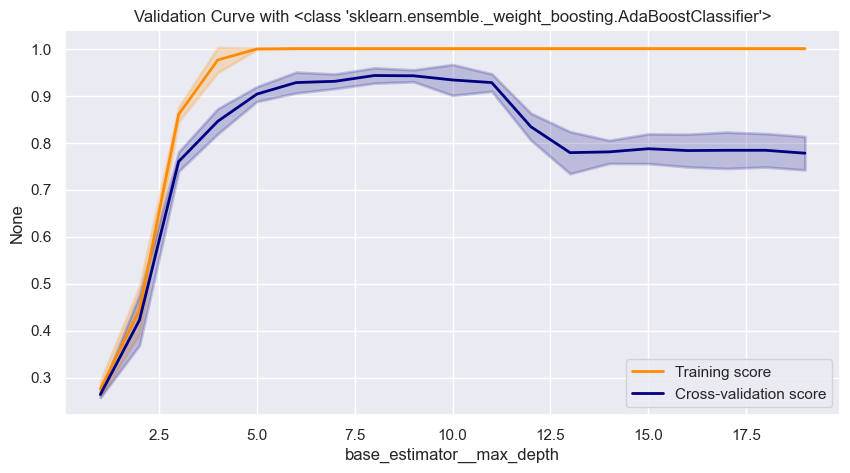

In [15]:
fig =plot_validation_curve(ada, X,y,cv=3, param_name='base_estimator__max_depth', param_range=np.arange(1,20))

In [ ]:
#The model it`s overfitting as can be seen on the graph
#Proper max_depth could be to choose max_depth=8
#The training score=1 this means the model will absolutely overfit as can be seen in the shape of the cross-validation score.
#after max_dept=11 it drops

In [16]:
forest=RandomForestClassifier(n_estimators=100)
param_grid={'max_depth':[2,10,20],
            'min_samples_leaf':[2,10,20]}
grid1=GridSearchCV(forest, param_grid,cv=3)

In [17]:
grid1.fit(X,y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 10, 20],
                         'min_samples_leaf': [2, 10, 20]})

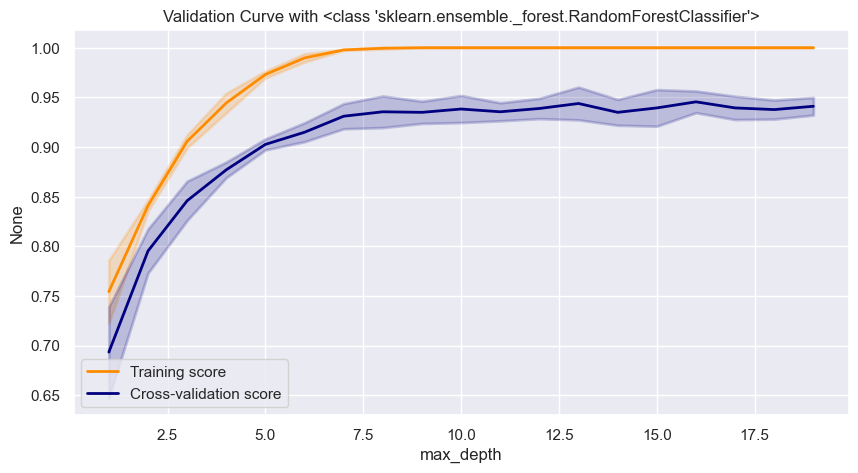

In [18]:
fig =plot_validation_curve(forest, X,y,cv=3, param_name='max_depth', param_range=np.arange(1,20))

#https://scikit-learn.org/0.20/auto_examples/model_selection/plot_validation_curve.html

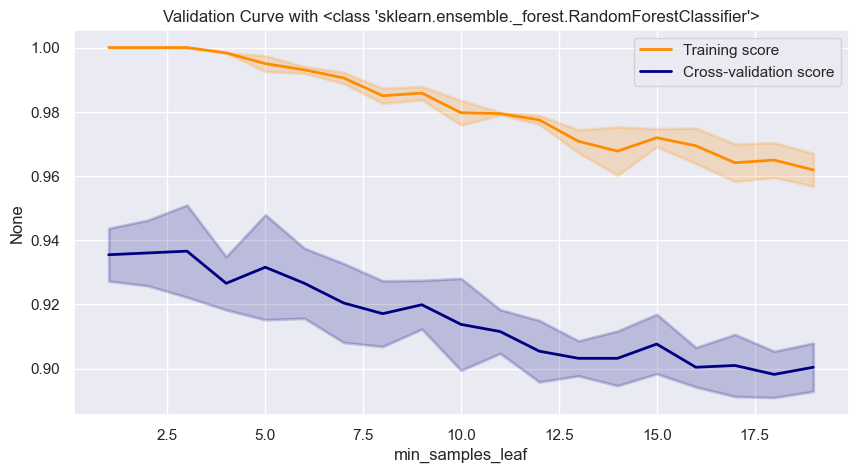

In [19]:
fig =plot_validation_curve(forest, X,y,cv=3, param_name='min_samples_leaf', param_range=np.arange(1,20))

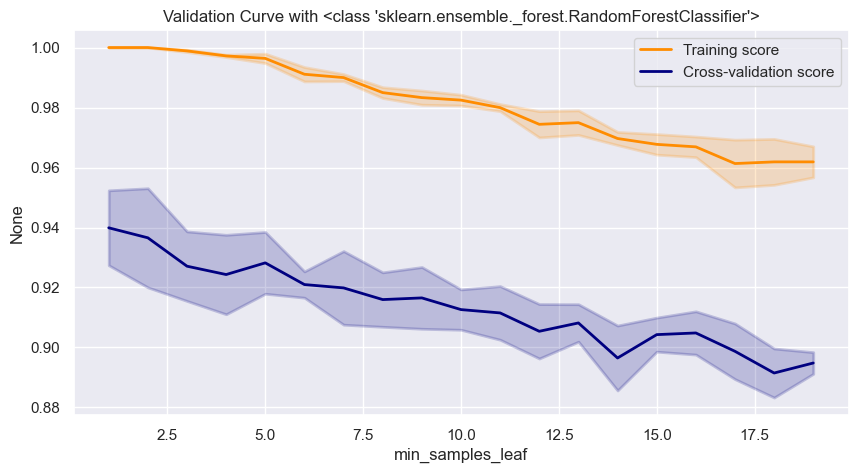

In [20]:
fig =plot_validation_curve(grid1.best_estimator_, X,y,cv=3, param_name='min_samples_leaf', param_range=np.arange(1,20))

In [21]:
grid1.best_params_

{'max_depth': 10, 'min_samples_leaf': 2}

We actually did not split the data into Train and Test because we already uploaded the data already only for test.

The most correct way would be to split, we didn`t` do it do to what we mentioned above